# Exploratory Data Analysis

In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

pd.set_option("display.max_columns", None)

In [41]:
df = pd.read_csv('../data/data.csv')

***
## SECTION 1: BASIC INSPECTION OF THE DATASET

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

#### Objective here is to check:
- min, max, mean and standard deviation for anomalies
- how many unique values does columns have (to better understand them, and decide how to further analyse them)

In [43]:
print(df.shape)
df.describe(include='all')

(30697, 25)


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
count,30697,30697,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697,30697.000000,30697.000000,25697.000000,30697,30697,30697,30697,3.069700e+04,30697,30697,30697,30697,30697.000000
unique,57,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,2,6,7,5,NaN,1,1559,74,33,NaN
top,Jump Shot,Jump Shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-06,NaN,NaN,NaN,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,NaN,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS,NaN
freq,18880,23485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2318,NaN,NaN,NaN,24271,13455,12625,9398,NaN,30697,50,1020,1978,NaN
mean,NaN,NaN,249.190800,3.562192e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,NaN,28.365085,13.437437,0.446161,NaN,NaN,NaN,NaN,1.610613e+09,NaN,NaN,NaN,NaN,15349.000000
std,NaN,NaN,150.003712,1.902401e+09,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,NaN,17.478949,9.374189,0.497103,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,8861.604943
min,NaN,NaN,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,1.610613e+09,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,NaN,13.000000,5.000000,0.000000,NaN,NaN,NaN,NaN,1.610613e+09,NaN,NaN,NaN,NaN,7675.000000
50%,NaN,NaN,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,NaN,28.000000,15.000000,0.000000,NaN,NaN,NaN,NaN,1.610613e+09,NaN,NaN,NaN,NaN,15349.000000
75%,NaN,NaN,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,NaN,43.000000,21.000000,1.000000,NaN,NaN,NaN,NaN,1.610613e+09,NaN,NaN,NaN,NaN,23023.000000


## SECTION 2: Removing Redundant Columns
There are some columns that have very high corelations with some other columns and some columns that

Removing columns:
- team_name, team_id - These have only a single value, so it doesn't add any value to the prediction
- matchup - It has 1 to 1 corelation with the column "opponent"
- shot_id 

In [44]:
columns_to_drop = ['team_name', 'team_id', 'shot_id']
df = df.drop(labels=columns_to_drop, axis='columns')
print(f"Total columns removed: {len(columns_to_drop)}")

Total columns removed: 3


## Section 3: Dealing With Missing Values

In [45]:
def remove_na_rows(df: pd.DataFrame):
    """
    :param pd.DataFrame df:
    :return pd.DataFrame
    """
    num_rows_before = len(df)
    print(f'Number of rows: {num_rows_before}')
    df = df.dropna()
    num_rows_after = len(df)
    print(f'Number of rows after dropping missing values: {num_rows_after}')
    removed_rows = num_rows_before - num_rows_after
    print(f'Percentage of data removed: {100 * (removed_rows/num_rows_before)} %')
    return df

df = remove_na_rows(df)
print(df.shape)

Number of rows: 30697
Number of rows after dropping missing values: 25697
Percentage of data removed: 16.28823663550184 %


## Section 4: Outlier detection
From our analysis of the above data (mostly looking at mean, min, max) we can see that most likely there no outliers. But still we will have a thorough look at all the columns to understand them and confirm that there is no outliers. 

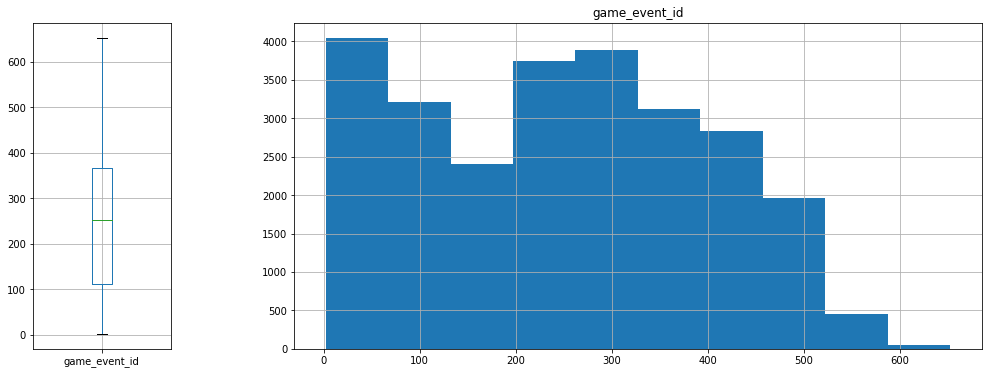

In [46]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='game_event_id',ax=axes[0]);
df.hist(column='game_event_id', ax=axes[1]);

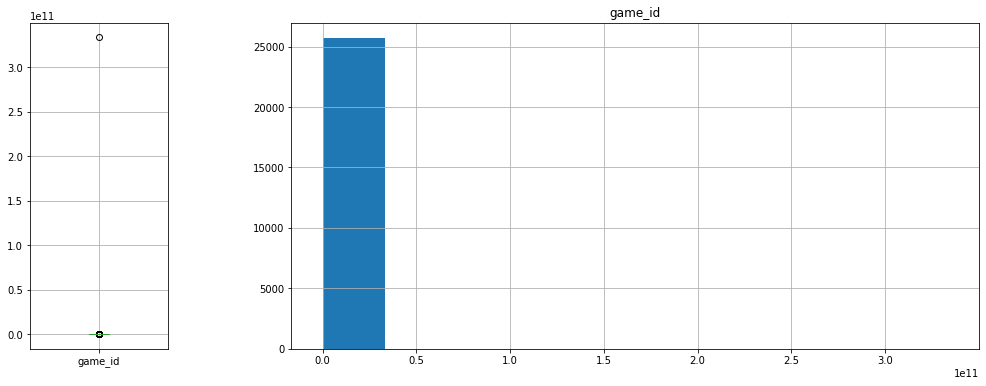

In [47]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='game_id',ax=axes[0]);
df.hist(column='game_id', ax=axes[1]);

These are not outliers, 'game_id' is unique number associated with a single match. In this case it just so happens
that in the number system some matches an ID of very high value, but from the overall structre of the above bar chart everything looks good.

#### For Column: `lat`, `lon`, `loc_x`, `loc_y`

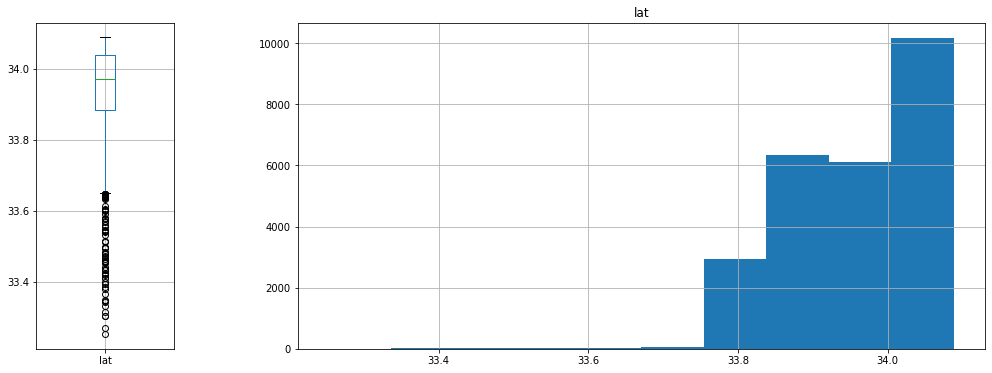

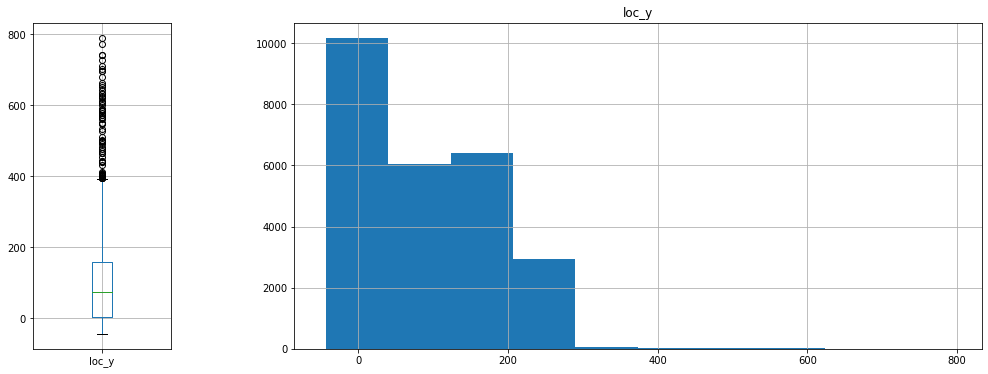

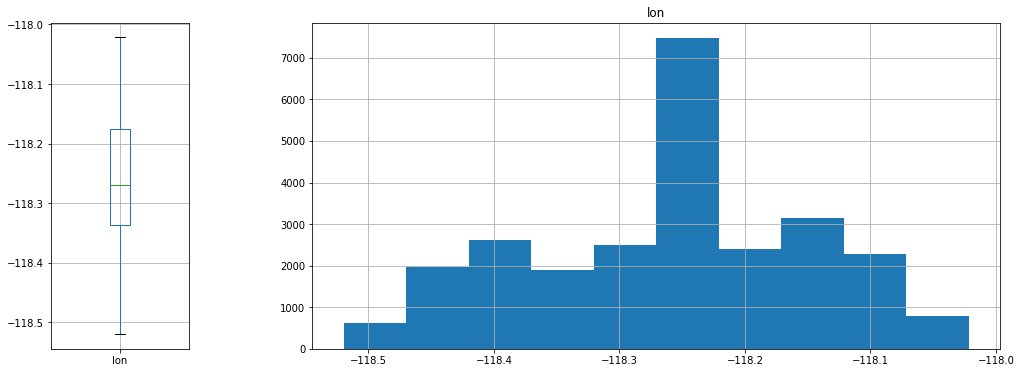

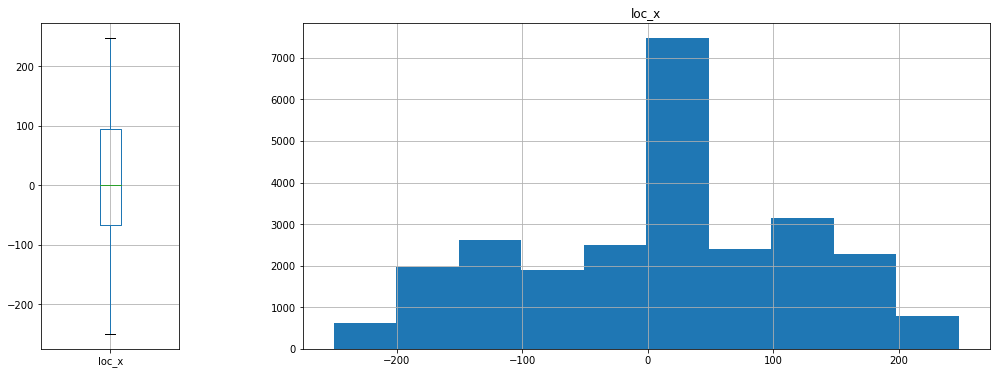

In [48]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='lat',ax=axes[0]);
df.hist(column='lat', ax=axes[1]);

fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='loc_y',ax=axes[0]);
df.hist(column='loc_y', ax=axes[1]);

fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='lon',ax=axes[0]);
df.hist(column='lon', ax=axes[1]);

fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='loc_x',ax=axes[0]);
df.hist(column='loc_x', ax=axes[1]);

From this we can see that (`lat`, `lon`) and (`loc_x`, `loc_y`) present the same information just in different encoding. This allows us to drop 2 additional columns as they provide the same information.

Also It looks in `lat` and `loc_y` that there might be lot of outliers, but the below diagram tell shows us that, these points are not outliers. In this case these points should be within the court boundry, if that is the case then they are not outliers, as we can see below.

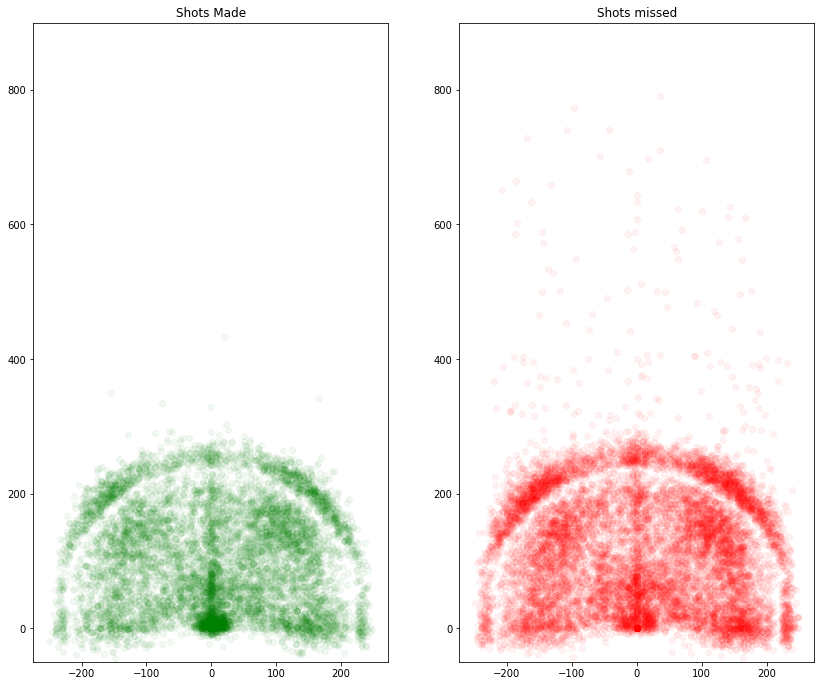

In [49]:
court_scale, alpha = 7, 0.05
plt.figure(figsize=(2 * court_scale, court_scale*(84.0/50.0)))
# hit
plt.subplot(121)
h = df.loc[df.shot_made_flag == 1]
plt.scatter(h.loc_x, h.loc_y, color='green', alpha=alpha)
plt.title('Shots Made')
ax = plt.gca()
ax.set_ylim([-50, 900])
# miss
plt.subplot(122)
h = df.loc[df.shot_made_flag == 0]
plt.scatter(h.loc_x, h.loc_y, color='red', alpha=alpha)
plt.title('Shots missed')
ax = plt.gca()
ax.set_ylim([-50, 900])
plt.savefig('shots_made_and_missed.png')

Since (`lat`, `lon`) and (`loc_x`, `loc_y`) present the same information we can drop a pair. 
We have decided to drop the columns: `lat`, `lon` in this case.

#### For Column: `minutes_remaining` & `seconds_remaining`

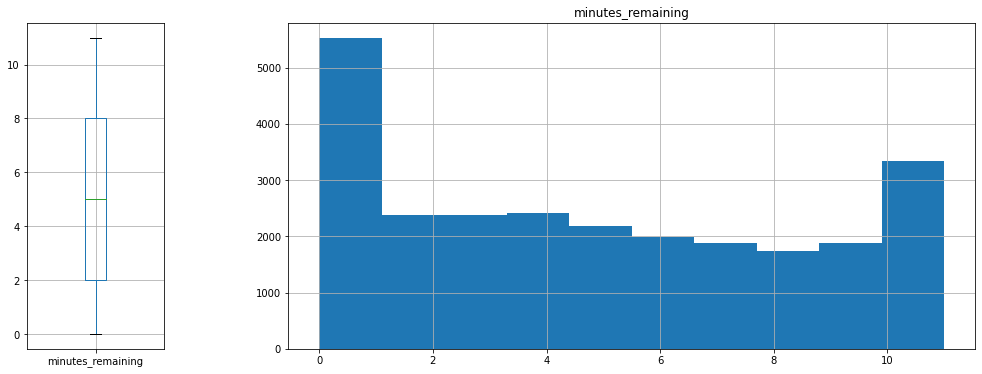

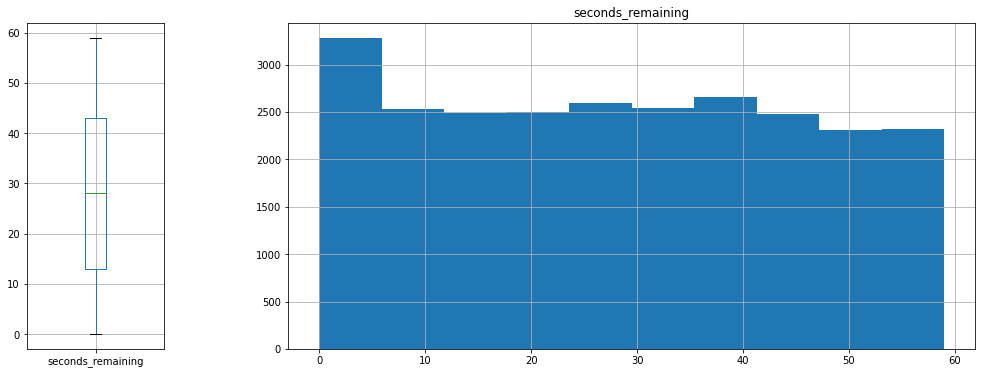

In [51]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='minutes_remaining',ax=axes[0]);
df.hist(column='minutes_remaining', ax=axes[1]);

fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='seconds_remaining',ax=axes[0]);
df.hist(column='seconds_remaining', ax=axes[1]);

#### For Column: `period` & `playoffs`

In [53]:
print( df["period"].value_counts() )
print( df["playoffs"].value_counts() )

3    7002
1    6700
4    6043
2    5635
5     280
6      30
7       7
Name: period, dtype: int64
0    21939
1     3758
Name: playoffs, dtype: int64


#### For Column: `shot_distance`

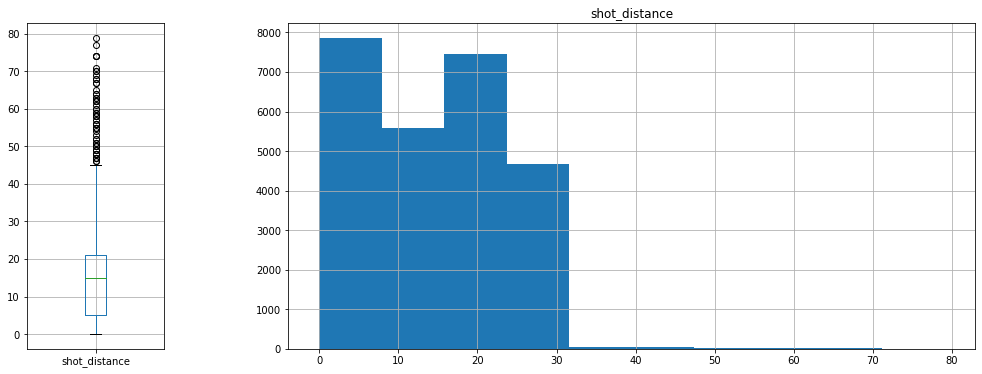

In [54]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(17,6))
df.boxplot(column='shot_distance',ax=axes[0]);
df.hist(column='shot_distance', ax=axes[1]);

As we saw with `lat` and `loc_y`, there are few shots that were made far away from the hoop. So these are not outliers but rather the minority shots. 

We might need to normalize this column.